In [7]:
#!/usr/bin/python

# Import required modules
import os
import sys
sys.path.append('..')
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utilities
from tools import load_json
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Initial setup

In [8]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [9]:
# Load IZA cantons
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
n_iza = len(iza_cantons)

# Linear regression of molar volumes and energies

In [10]:
deem_dir = '../../Processed_Data/DEEM_330k/Data'
iza_dir = '../../Processed_Data/IZA_230/Data'

## Deem 10k train set

In [11]:
# Load train and test set indices for Deem
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test.idxs', dtype=int)
n_deem_train = len(deem_train_idxs)
n_deem_test = len(deem_test_idxs)

In [12]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_structure_properties = {}
deem_predicted_structure_properties = {}

iza_structure_properties = {}
iza_predicted_structure_properties = {}
for pn in property_names:
    property_label = pn.capitalize()
    
    deem_structure_properties[pn] = np.loadtxt(f'{deem_dir}/structure_{pn}.dat')
    iza_structure_properties[pn] = np.loadtxt(f'{iza_dir}/structure_{pn}.dat')
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')

In [13]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.40	2.79
IZA:	--	230	--	5.30

IZA1:	--	35	--	4.63
IZA2:	--	126	--	5.14
IZA3:	--	68	--	5.36
IZA4:	--	1	--	44.91

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.60	0.65
IZA:	--	230	--	0.97

IZA1:	--	35	--	1.00
IZA2:	--	126	--	0.87
IZA3:	--	68	--	0.92
IZA4:	--	1	--	15.80

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.02	1.12
IZA:	--	230	--	1.63

IZA1:	--	35	--	0.87
IZA2:	--	126	--	1.49
IZA3:	--	68	--	1.85
IZA4:	--	1	--	30.86

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.08	0.11
IZA:	--	230	--	0.11

IZA1:	--	35	--	0.15
IZA2:	--	126	--	0.08
IZA3:	--	68	--	0.10
IZA4:	--	1	--	3.75



## Deem random train set

In [14]:
# Load train and test set indices for Deem
deem_train_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train_random.idxs', dtype=int)
deem_test_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test_random.idxs', dtype=int)
n_deem_train = len(deem_train_idxs_random)
n_deem_test = len(deem_test_idxs_random)

In [15]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_predicted_structure_properties = {}
iza_predicted_structure_properties = {}
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')

In [16]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs_random]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs_random]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.47	2.40
IZA:	--	230	--	5.05

IZA1:	--	35	--	4.61
IZA2:	--	126	--	4.73
IZA3:	--	68	--	5.22
IZA4:	--	1	--	50.38

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.63	0.64
IZA:	--	230	--	0.91

IZA1:	--	35	--	1.00
IZA2:	--	126	--	0.85
IZA3:	--	68	--	0.95
IZA4:	--	1	--	4.18

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.05	1.05
IZA:	--	230	--	1.58

IZA1:	--	35	--	0.85
IZA2:	--	126	--	1.43
IZA3:	--	68	--	1.79
IZA4:	--	1	--	31.28

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.08	0.11
IZA:	--	230	--	0.12

IZA1:	--	35	--	0.16
IZA2:	--	126	--	0.09
IZA3:	--	68	--	0.10
IZA4:	--	1	--	3.56



## DEEM 330k analysis

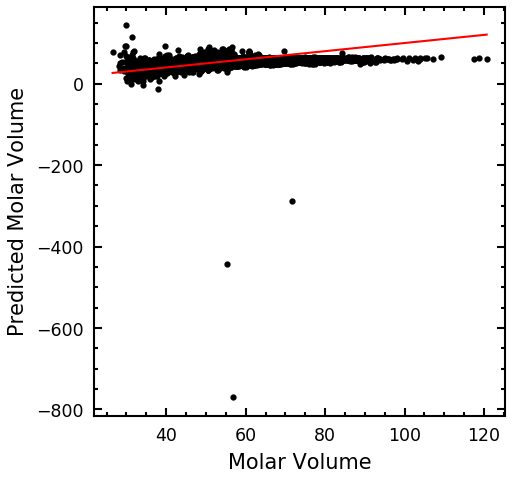

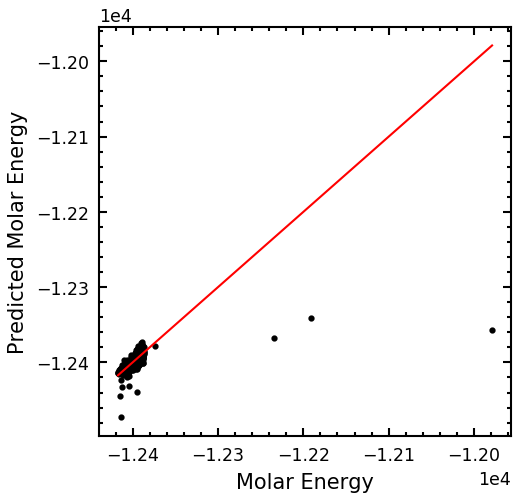

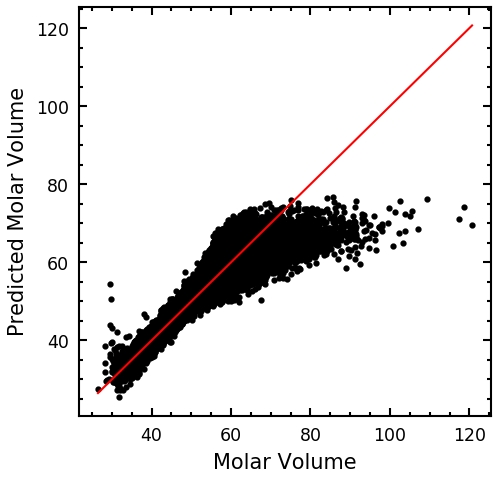

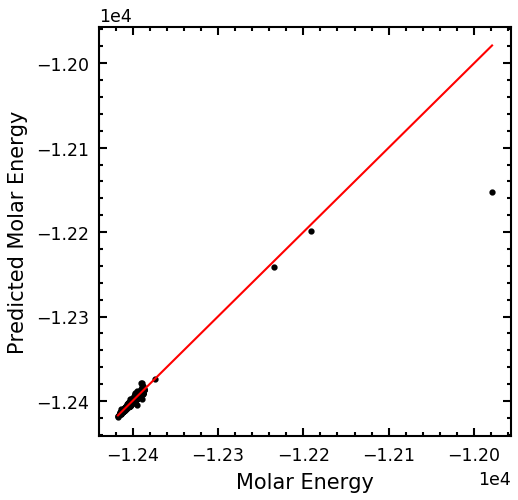

In [17]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        plt.scatter(
            deem_structure_properties[pn], 
            deem_predicted_structure_properties[cutoff][pn]
        )
        plt.plot(
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.show()

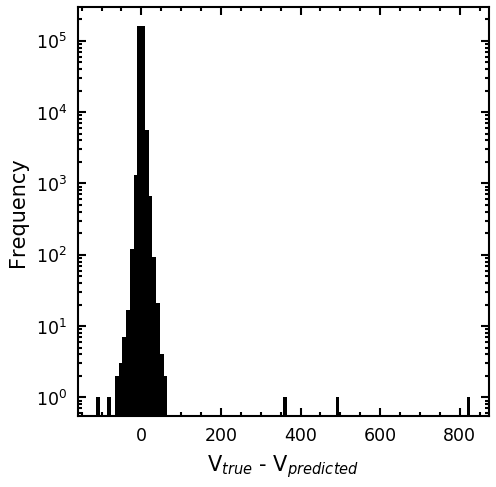

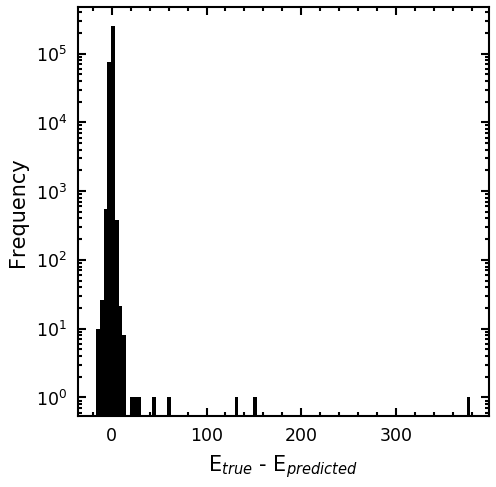

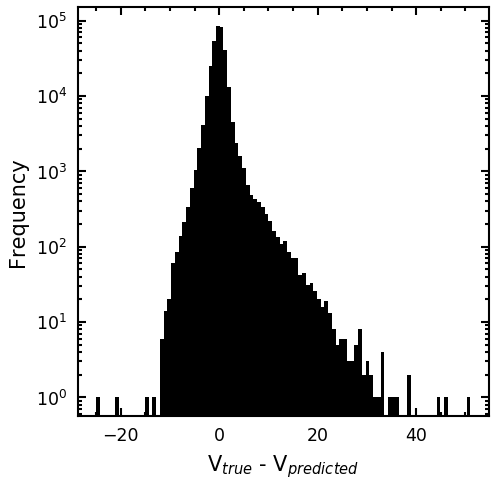

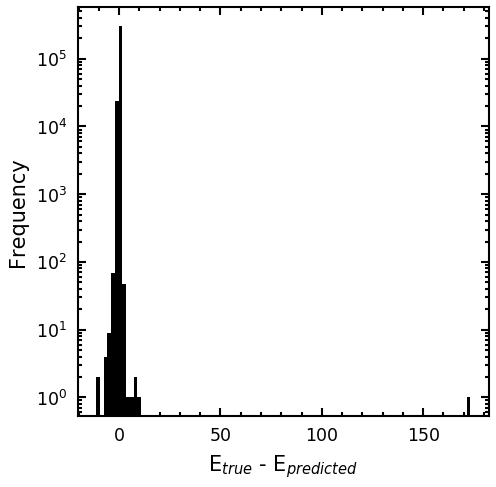

In [18]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [19]:
deem_codes = np.arange(0, len(deem_structure_properties['volumes'])) + 8000001

In [20]:
n_show = 100
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c in zip(errors[idxs][-n_show:], deem_codes[idxs][-n_show:]):
            print(f'{c}\t\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
8321822		30.388457523416726
8328225		30.480388748926963
8307987		30.517693050346864
8322885		30.553745399353403
8128697		30.573820563665414
8079879		30.582215844830174
8267043		30.591706141206473
8325400		30.632068304392433
8316033		30.656821790644806
8056798		30.699562006757972
8285459		30.74824776894708
8327932		30.82484002009918
8311326		30.841221657322336
8068129		30.91705544641861
8307137		31.201331686292868
8295487		31.29348883436829
8248695		31.30872059834857
8274922		31.39561847570672
8129594		31.464829224906516
8307691		31.653504994543127
8308288		31.698082811941354
8325055		31.812038861573797
8318835		31.866906162438184
8329775		31.92380131234315
8312657		31.978831384173787
8323191		32.498927194385004
8319194		32.50312914487931
8116204		32.57799938261639
8200851		32.59013436139121
8320103		32.603804132132
8327293		32.60513386799259
8307129		32.859961813574955
8261270		32.92946382180381
8326900		33.13436579804855
8037824		33.29950529542481

In [21]:
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)
deem_delete_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [22]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        print(f'-----Problem structures for {cutoff} {pn}-----')
        for i in range(1, 11):
            idxs_high = np.nonzero(errors >= mean_error + i * std_error)[0]
            idxs_low = np.nonzero(errors <= mean_error - i * std_error)[0]
            idxs_all = np.concatenate((idxs_low, idxs_high))
            in_deem_10k = np.intersect1d(deem_10k_idxs, idxs_all)
            in_deem_delete = np.intersect1d(deem_delete_idxs, idxs_all)
            for idxs in (idxs_all, in_deem_10k, in_deem_delete):
                idxs += 8000001
            print(f'{i}-sigma ({len(idxs_all)}, {len(in_deem_delete)}, {len(in_deem_10k)})')
            print(idxs_all)
        print('')

-----Problem structures for 3.5 volumes-----
1-sigma (28877, 3, 837)
[8000008 8000022 8000028 ... 8331161 8331163 8331164]
2-sigma (8647, 3, 250)
[8000022 8000070 8000097 ... 8331136 8331156 8331164]
3-sigma (3523, 3, 97)
[8000022 8001711 8001755 ... 8331120 8331121 8331135]
4-sigma (1829, 3, 58)
[8001711 8002048 8002590 ... 8331020 8331110 8331121]
5-sigma (958, 3, 33)
[8002048 8004390 8009564 8014803 8016387 8022741 8026995 8027927 8028083
 8035895 8037822 8037824 8037922 8037968 8037974 8038063 8038078 8038136
 8038164 8038284 8038300 8038314 8042929 8044737 8045577 8045578 8045580
 8047317 8047564 8047801 8048031 8048032 8051224 8052218 8054009 8054159
 8054161 8055726 8055842 8055999 8056796 8056798 8056809 8056820 8056830
 8056864 8059332 8059343 8059483 8059484 8059805 8060366 8060369 8060378
 8062817 8062865 8063080 8067656 8067891 8067892 8067893 8067909 8068089
 8068097 8068112 8068115 8068129 8068953 8069913 8072749 8077929 8078021
 8078124 8079810 8079879 8079884 8082032 80

## IZA 230 analysis

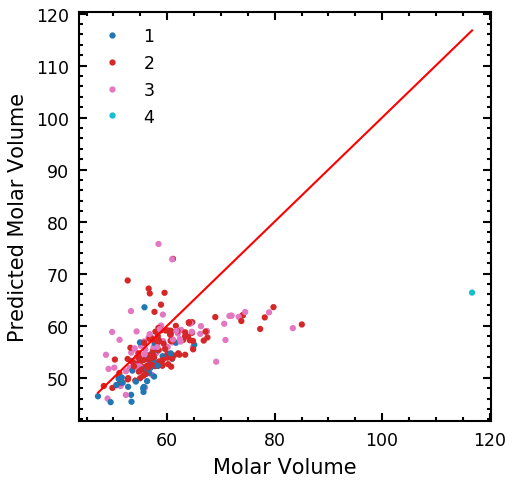

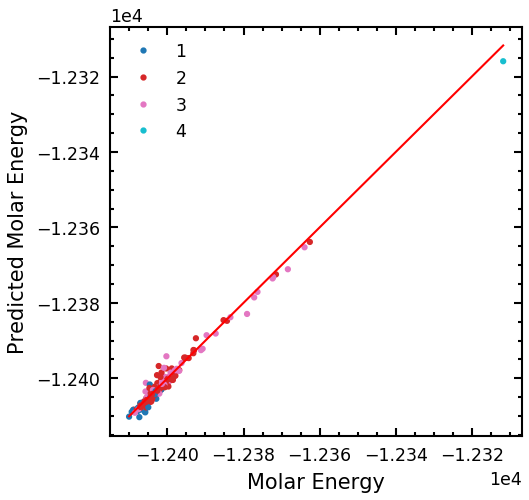

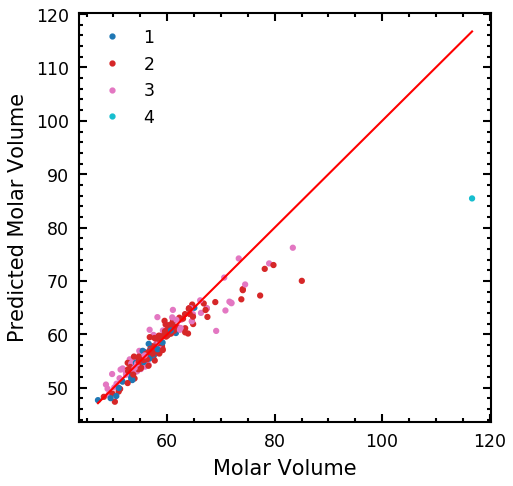

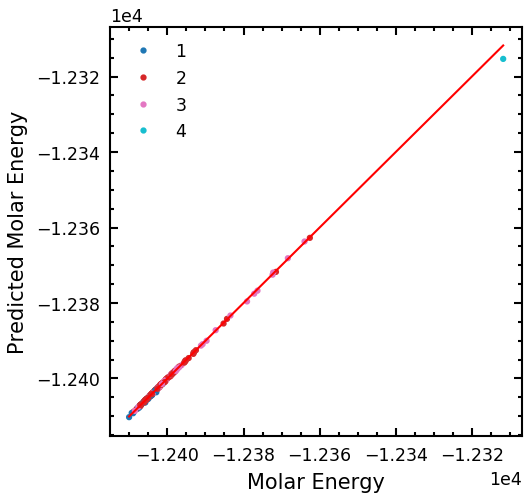

In [23]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        scatter = plt.scatter(
            iza_structure_properties[pn], 
            iza_predicted_structure_properties[cutoff][pn],
            c=iza_cantons, cmap='tab10'
        )
        plt.plot(
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.legend(*scatter.legend_elements())
        plt.show()

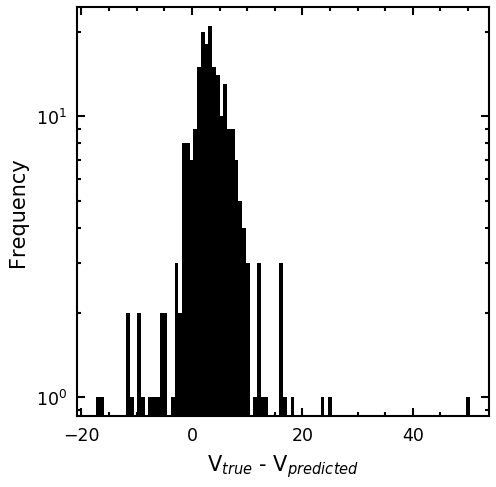

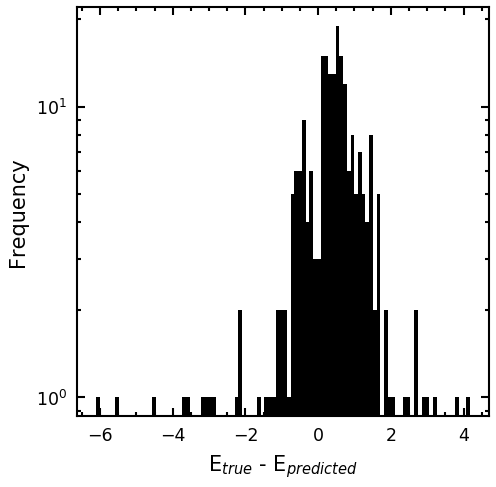

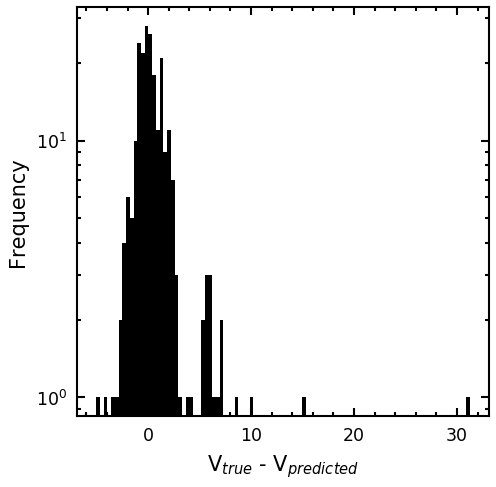

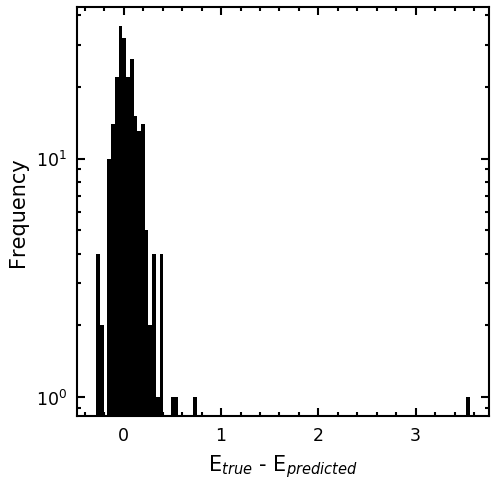

In [24]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            iza_structure_properties[pn] - iza_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [25]:
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype=str)

In [26]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(iza_structure_properties[pn] -  iza_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c, cc in zip(errors[idxs], iza_cantons[idxs], iza_codes[idxs]):
            print(f'{c}\t{cc[0:3]}\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
2	SOR	0.05770357095411782
2	BRE	0.08252138565990919
1	ETL	0.11543159915186862
2	JBW	0.18610080921416738
2	STI	0.21470474349147395
2	MVY	0.22070490209187454
2	PHI	0.26422878716825693
3	DFT	0.34860142502226665
3	POR	0.5156155073712867
2	ABW	0.6101692169789388
2	SOF	0.6263165301212439
1	MTF	0.6839677671163287
2	LTL	0.7216511162399399
3	SIV	0.7222561595786203
2	MRT	0.7674544264802563
2	ETV	0.7749491511581823
2	MSO	0.7881047491025868
2	LAU	0.8552010499448173
2	SZR	0.8678908139363344
2	CAS	0.9457646657420327
3	BOF	0.9593715521030077
2	VNI	0.9620848473241068
2	LTJ	0.9727178951455002
2	MWF	0.9759280629188538
1	LTF	0.9896104710958866
2	MOZ	1.0465211116429813
3	APC	1.047757632474692
3	JRY	1.0845597480204034
2	LOV	1.095067181550128
3	AHT	1.1260125146075524
3	ACO	1.1584375047621691
3	ATT	1.1679615885656247
3	ATN	1.1726852635536815
2	GIS	1.2080753641631006
3	ZON	1.2299323848541732
1	NSI	1.2539060039790826
3	JSN	1.2843278517819385
3	AFN	1.2904563922133647
2	MAZ	